# 3. Creating the classifier

In [1]:
# Author: Louis Enslin

In [2]:
# Importing all needed libraries also our own DeepWorkOut
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from scipy.spatial import distance
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn import tree

from DeepWorkOut import Analyzer
from DeepWorkOut import MultiAnalyzer
import warnings
warnings.filterwarnings('ignore')

In C:\tools\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\tools\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\tools\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\tools\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\tools\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quali

### Data preparation

From folder import all dataframes from the given videos, used as training and test data

In [3]:
folderPath = 'C:\\Users\\ufxds\\Desktop\\DeepWorkOut\\PostAnalysis\\Analysed_pandas\\'
DLCscorer = 'DLC_resnet101_DeepWorkOutJan31shuffle3_100000'
fps = 30
# creates the base for analyzing the videos in a pipeline
multiVideos = MultiAnalyzer(folderPath, DLCscorer, fps)


- Set here which bodyparts are used later to get features and then clean the video data
- Remove all videos which are rated as not useful

In [4]:
needed_bodyparts = ['ankleleft', 'forehead', 'shoulderleft', 'kneeleft', 'hipleft', 'elbowleft']
unvalid_videos = multiVideos.clean_data(needed_bodyparts, pcutoff = 0.5, min_rate = 0.9)
multiVideos.calibrate_metric('ankleleft', 'kneeleft', 42.0)
valid_bpts = list(multiVideos.getValidBodyparts())
print(str(len(unvalid_videos)) + ' videos were removed.')

11 videos were removed.


- Creates the dataframe which contains all videos and their 200 features
- Creates also the label data
- Splits data in train and test

In [5]:
features = pd.DataFrame()
for video in multiVideos.videos:
    feature_dict = video.get_Features(valid_bpts)
    feature_dict['exercise'] = video.exercise
    features = features.append(feature_dict, ignore_index=True)
#features.set_index('exercise', inplace=True)   
y = features['exercise']
X = features.drop(columns=['exercise'])
feature_names = (X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Visualize data with PCA 

Mean center all data for the PCA

In [6]:
scaler = StandardScaler(with_std=False)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_names)
y_train_series = pd.Series(y_train, name='exercise')
y_test_series = pd.Series(y_test, name='exercise')

In [7]:
def plotPCAVariance(var_exp, X):

    cum_var_exp = np.cumsum(var_exp)
   
    #plotting individual explained variance is given
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    ax.bar(range(1, X.shape[0]+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')    
    ax.set_xlim(0.5, X.shape[0]+1.5)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(np.arange(1,100+1,3))

    # plotting
    ax.step(range(1, X.shape[0]+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
    ax.legend(loc='best')
    return fig, ax

Plot PCA result

(55, 163)


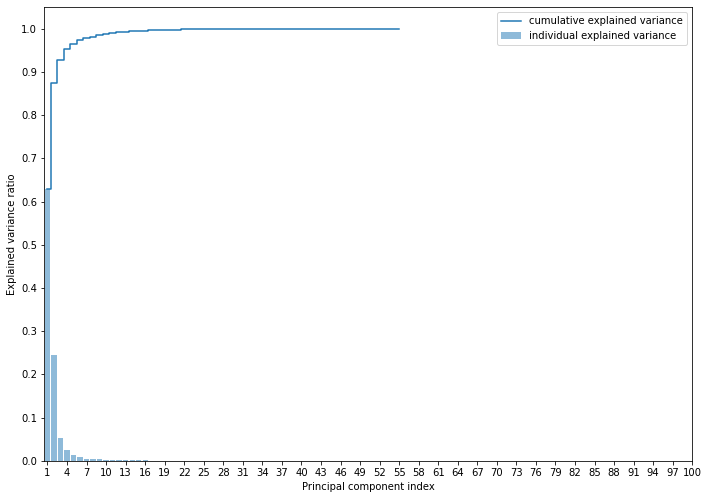

In [8]:
pca = PCA().fit(X_train_scaled)
# get explained variance
var_exp = pca.explained_variance_ratio_
print(X_train_scaled.shape)
# plot
fig, ax = plotPCAVariance(var_exp, X_train_scaled)

- transform the whole dataset to with PCA (not only train data)
- create labels to show in legend
- plot scatter visualization

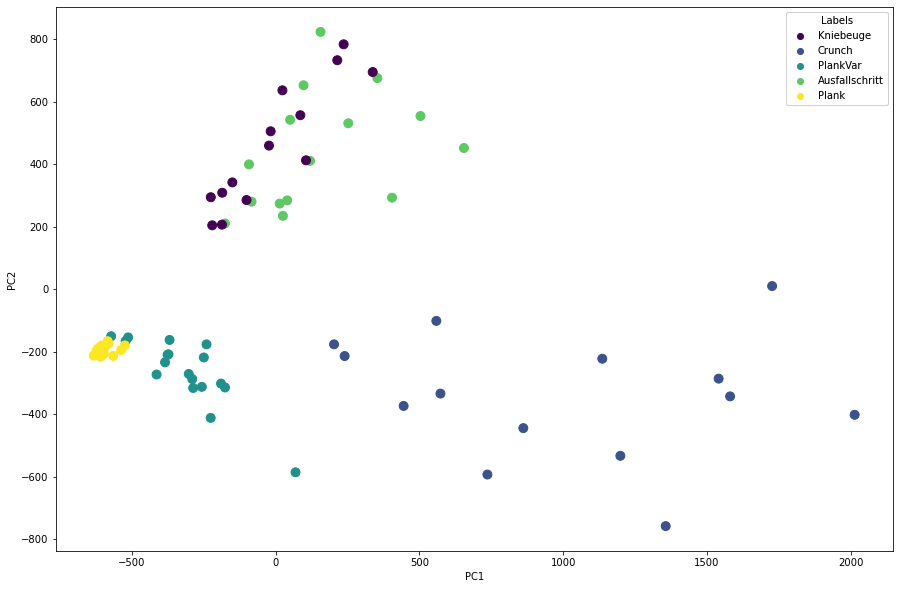

In [9]:
X_pca = pca.fit_transform(scaler.transform(X))
class_names=['Kniebeuge', 'Crunch', 'PlankVar', 'Ausfallschritt', 'Plank']
labels_to_num= dict(zip(class_names, range(1,6)))
y_labels = y.map(labels_to_num, na_action='ignore')

fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_labels, s=80, cmap='viridis')
handles, labels = scatter.legend_elements()
legend = ax.legend(handles, class_names, loc="upper right", title="Labels")
ax.add_artist(legend)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

### Train  different models (KNN & DecisionTree)

Here can be set which data should be used to train model (PCA or not)

In [10]:
pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
total_variance = pca.explained_variance_ratio_.sum()
X_test_pca = pca.transform(X_test_scaled)
print('Variance reached with PCA: ' + str(total_variance))
X_train_to_use = X_train
X_test_to_use = X_test

Variance reached with PCA: 0.9882089495425275


Set parameters for gridsearch 

In [11]:
parameters_tree = {'max_depth': [None, 1, 2, 3, 4, 5, 10, 15], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]}
parameters_knn = {'n_neighbors': range(2,11), 'weights': ['uniform', 'distance']}

Train decionTree with different parameters

In [12]:
clf_tree = DecisionTreeClassifier(random_state=42)
grid_search_tree = GridSearchCV(clf_tree, parameters_tree, cv=2)
grid_search_tree.fit(X_train_to_use, y_train_series)

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 3, 4]})

Train KNN with different parameters

In [13]:
clf_knn = neighbors.KNeighborsClassifier()
grid_search_knn = GridSearchCV(clf_knn, parameters_knn, cv=3)
grid_search_knn.fit(X_train_to_use, y_train_series)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(2, 11),
                         'weights': ['uniform', 'distance']})

Print for each classifier the best parameters

In [14]:
best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_
best_estimator_tree = grid_search_tree.best_estimator_
print(best_params_tree)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}


In [15]:
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_
best_estimator_knn = grid_search_knn.best_estimator_
print(best_params_knn)

{'n_neighbors': 3, 'weights': 'uniform'}


Get accuracy of both classifiers

In [16]:
y_pred_tree = best_estimator_tree.fit(X_train_to_use, y_train_series).predict(X_test_to_use)
y_pred_knn = best_estimator_knn.fit(X_train_to_use, y_train_series).predict(X_test_to_use)
acc_tree = metrics.accuracy_score(y_test_series, y_pred_tree)
acc_knn = metrics.accuracy_score(y_test_series, y_pred_knn)

print('Accuracy of Decision Tree: {}%'.format((acc_tree * 100).round(2)))
print('Accuracy of KNN: {}%'.format((acc_knn * 100).round(2)))

Accuracy of Decision Tree: 91.67%
Accuracy of KNN: 95.83%


### Visualization of decisionTree

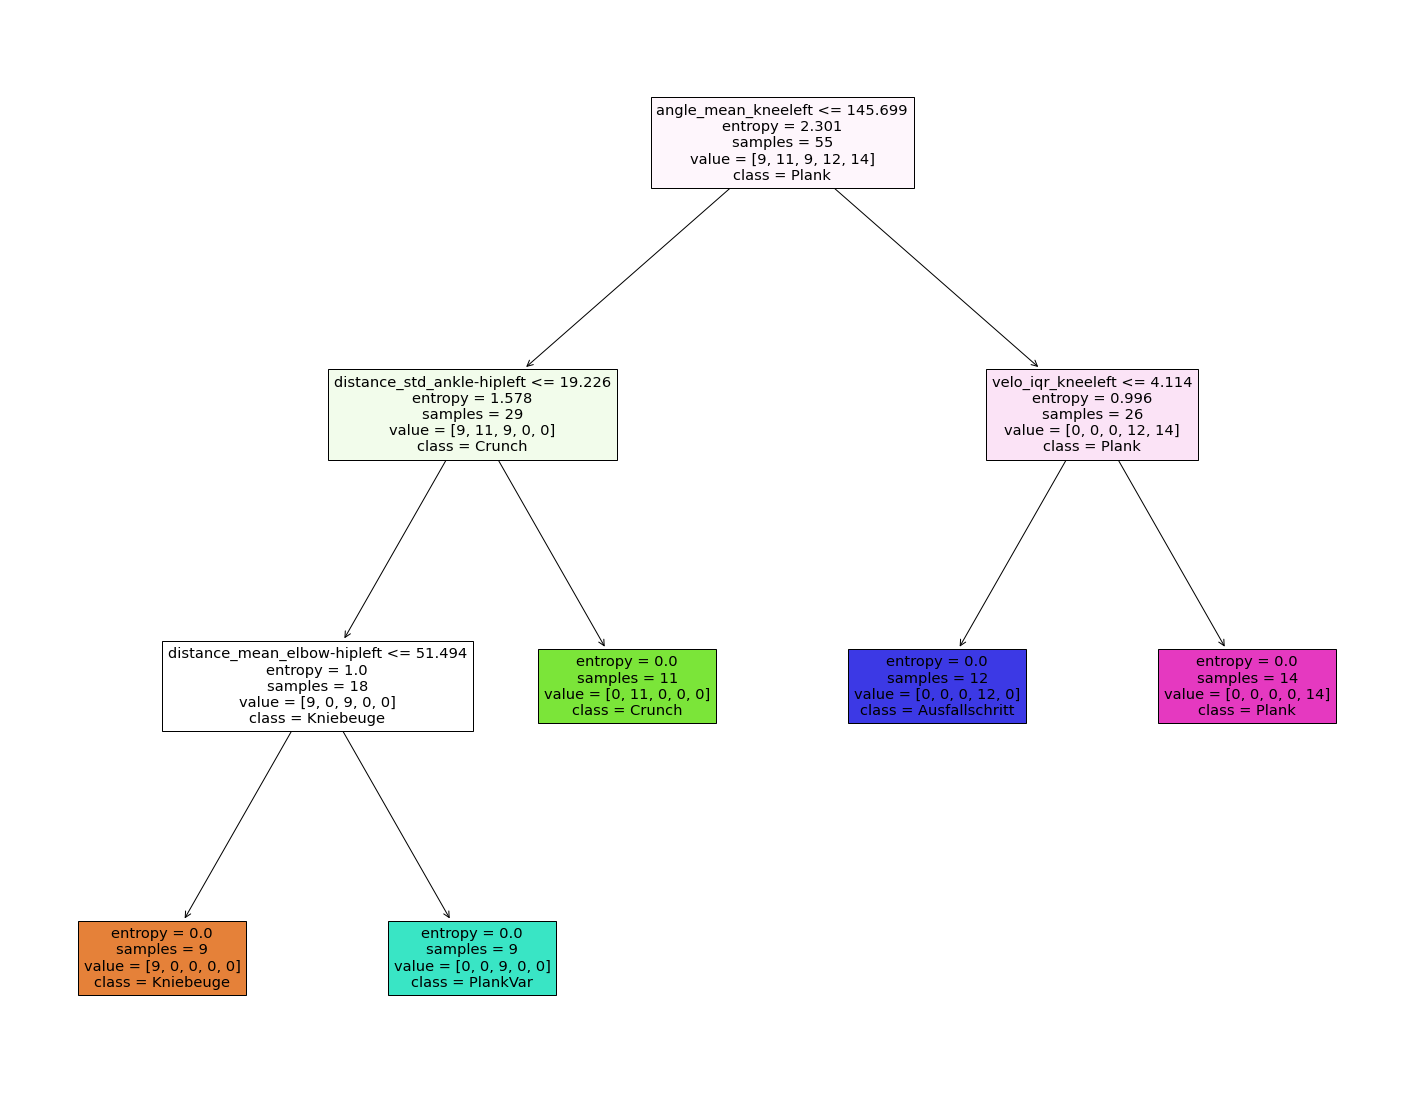

In [17]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_estimator_tree, feature_names=feature_names,  
                   class_names=['Kniebeuge', 'Crunch', 'PlankVar', 'Ausfallschritt', 'Plank'],
                   filled=True)
